In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import mudata as md
import os
import sys
import pooch
import scanpy as sc
import leidenalg
import scanpy.external as sce
import matplotlib.pyplot as plt
import muon as mu
from muon import prot as pt

/data/msun/miniconda3/envs/citeseq/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import mofax as mofa

In [3]:
sys.path.append('/data/msun/projects/Stephen/PDAC_scRNA/')
from core_functions.processing import *

In [4]:
sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    frameon=False,
)

In [5]:
# Filter out warnings to minimize clutter
import warnings
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)

In [6]:
sc.settings.n_jobs = -1

# Load data

In [7]:
mdata = mu.read_10x_mtx(path="/data/msun/projects/Stephen/PDAC_scRNA/raw_data/filtered_feature_bc_matrix/")
mdata

MuData object with n_obs × n_vars = 11205 × 55639
  var:	'gene_ids', 'feature_types'
  2 modalities
    rna:	11205 x 55487
      var:	'gene_ids', 'feature_types'
    prot:	11205 x 152
      var:	'gene_ids', 'feature_types'

## Demultiplex Hashtags

In [8]:
hashtags = ['HT1', 'HT2', 'HT3', 'HT4', 'HT5', 'HT6', 'HT7']
mdata.obs[hashtags] = mdata[:,hashtags].mod['prot'].X.todense() # move the hashtag value from prot to the obs 
mdata = mdata[:, ~mdata.var['gene_ids'].isin(hashtags)] # remove them from the gene expression.
sce.pp.hashsolo(mdata, hashtags) # assign each cell to a hashtag

Please cite HashSolo paper:
https://www.cell.com/cell-systems/fulltext/S2405-4712(20)30195-2


In [9]:
mdata.obs

HT1    HT2  HT3    HT4    HT5     HT6  HT7  \
AAACCTGAGACTAGGC-1  739.0    4.0  1.0    2.0    5.0  1334.0  5.0   
AAACCTGAGCAAATCA-1    1.0    7.0  4.0    5.0  597.0     2.0  4.0   
AAACCTGAGCAACGGT-1    3.0    6.0  6.0    6.0    3.0  1943.0  4.0   
AAACCTGAGCCACGCT-1    1.0    1.0  0.0    7.0  478.0    14.0  0.0   
AAACCTGAGCTAGCCC-1  532.0    1.0  0.0    1.0    0.0     0.0  0.0   
...                   ...    ...  ...    ...    ...     ...  ...   
TTTGTCATCGAGGTAG-1    3.0    3.0  5.0    2.0    1.0   523.0  2.0   
TTTGTCATCGCGTTTC-1    2.0  949.0  1.0   12.0    1.0     1.0  0.0   
TTTGTCATCGCTAGCG-1    2.0    2.0  0.0    1.0    0.0     1.0  0.0   
TTTGTCATCGTTACGA-1    3.0    2.0  1.0  414.0    0.0     0.0  0.0   
TTTGTCATCTGCGGCA-1    2.0    5.0  1.0    2.0   14.0  1062.0  2.0   

                    most_likely_hypothesis  cluster_feature  \
AAACCTGAGACTAGGC-1                     2.0              0.0   
AAACCTGAGCAAATCA-1                     1.0              0.0   
AAACCTGAGCAACGGT-1                     1.0              0.0   
AAACCTGAGCCACGCT-1                     1.0              0.0   
AAACCTGAGCTAGCCC-1                     1.0              0.0   
...                                    ...              ...   
TTTGTCATCGAGGTAG-1                     1.0              0.0   
TTTGTCATCGCGTTTC-1                     1.0              0.0   
TTTGTCATCGCTAGCG-1                     0.0              0.0   
TTTGTCATCGTTACGA-1                     1.0              0.0   
TTTGTCATCTGCGGCA-1                     1.0              0.0   

                    negative_hypothesis_probability  \
AAACCTGAGACTAGGC-1                     1.416970e-30   
AAACCTGAGCAAATCA-1                     1.750876e-12   
AAACCTGAGCAACGGT-1                     9.077353e-17   
AAACCTGAGCCACGCT-1                     4.471530e-13   
AAACCTGAGCTAGCCC-1                     1.478203e-12   
...                                             ...   
TTTGTCATCGAGGTAG-1                     5.147732e-14   
TTTGTCATCGCGTTTC-1                     1.013424e-14   
TTTGTCATCGCTAGCG-1                     9.853162e-01   
TTTGTCATCGTTACGA-1                     1.284205e-14   
TTTGTCATCTGCGGCA-1                     4.806086e-17   

                    singlet_hypothesis_probability  \
AAACCTGAGACTAGGC-1                    2.048562e-14   
AAACCTGAGCAAATCA-1                    9.912247e-01   
AAACCTGAGCAACGGT-1                    9.998654e-01   
AAACCTGAGCCACGCT-1                    7.443967e-01   
AAACCTGAGCTAGCCC-1                    9.999108e-01   
...                                            ...   
TTTGTCATCGAGGTAG-1                    9.999480e-01   
TTTGTCATCGCGTTTC-1                    9.292292e-01   
TTTGTCATCGCTAGCG-1                    1.467479e-02   
TTTGTCATCGTTACGA-1                    9.998493e-01   
TTTGTCATCTGCGGCA-1                    6.488726e-01   

                    doublet_hypothesis_probability Classification  
AAACCTGAGACTAGGC-1                        1.000000        Doublet  
AAACCTGAGCAAATCA-1                        0.008775            HT5  
AAACCTGAGCAACGGT-1                        0.000135            HT6  
AAACCTGAGCCACGCT-1                        0.255603            HT5  
AAACCTGAGCTAGCCC-1                        0.000089            HT1  
...                                            ...            ...  
TTTGTCATCGAGGTAG-1                        0.000052            HT6  
TTTGTCATCGCGTTTC-1                        0.070771            HT2  
TTTGTCATCGCTAGCG-1                        0.000009       Negative  
TTTGTCATCGTTACGA-1                        0.000151            HT4  
TTTGTCATCTGCGGCA-1                        0.351127            HT6  

[11205 rows x 13 columns]

In [10]:
mdata.obs['Classification'].value_counts()

Classification
Doublet     2089
HT1         2026
HT2         1850
HT4         1785
HT3         1500
HT6          971
HT5          498
Negative     408
HT7           78
Name: count, dtype: int64

In [11]:
# remove Doublets and Negative 
mdata = mdata[~mdata.obs['Classification'].isin(["Doublet","Negative"])]

In [12]:
## Assign the hashtags to the sample
HT_to_sample = {
    "HT1": "Spleen control",
    "HT2": "LFD_1",
    "HT3": "LFD_2",
    "HT4": "Soy_1",
    "HT5": "Soy_2",
    "HT6": "Fish_1",
    "HT7": "Fish_2",
}

mdata.obs['sample'] = mdata.obs.Classification.replace(HT_to_sample).astype("category")
mdata.update()

mdata.obs['sample'].value_counts()

sample
Spleen control    2026
LFD_1             1850
Soy_1             1785
LFD_2             1500
Fish_1             971
Soy_2              498
Fish_2              78
Name: count, dtype: int64

In [13]:
# assign hastages to the condition 
HT_to_condition = {
    "HT1": "Spleen control",
    "HT2": "LFD",
    "HT3": "LFD",
    "HT4": "Soy",
    "HT5": "Soy",
    "HT6": "Fish",
    "HT7": "Fish",
}

mdata.obs['condition'] = mdata.obs.Classification.replace(HT_to_condition).astype("category")
mdata.update()

mdata.obs['condition'].value_counts()

condition
LFD               3350
Soy               2283
Spleen control    2026
Fish              1049
Name: count, dtype: int64

# Protein

In [14]:
# reorder protein alphabetically
mdata.mod['prot'] = mdata.mod['prot'][:, mdata.mod['prot'].var_names.sort_values()]

In [15]:
mdata.mod['prot'].var_names

Index(['B220', 'BST2.PDCA1.CD317', 'BTLA.CD272', 'CCR2.CD192', 'CCR4.CD194',
       'CCR6', 'CCR7', 'CCR8', 'CD103', 'CD11A',
       ...
       'TCRVB8.1_TCRVB8.2', 'TCRVG1.1', 'TCRVG2', 'TCRVG3', 'TER119',
       'THY1.1.CD90.1', 'THY1.2', 'TIGIT', 'TNFRSF25.DR3', 'VISTA'],
      dtype='object', length=145)

In [16]:
sc.pp.calculate_qc_metrics(mdata.mod['prot'], inplace=True, percent_top=None)

In [17]:
prot = mdata.mod['prot'].copy()
#We can refer to an individual AnnData inside the MuData by defining a respective variable. 
#All the operations will be performed on the respective AnnData object inside the MuData as you would expect.

## load raw data for DSB normalization 


In [18]:
mdata_raw = mu.read_10x_mtx(path="/data/msun/projects/Stephen/PDAC_scRNA/raw_data/raw_feature_bc_matrix/")

# clean the raw object/ remove hastag expression from var 
mdata_raw = mdata_raw[:, ~mdata_raw.var['gene_ids'].isin(hashtags)]
mdata_raw

# This method uses background droplets defined by low RNA content in order to estimate background protein signal and remove it from the data. 

View of MuData object with n_obs × n_vars = 717574 × 55632
  var:	'gene_ids', 'feature_types'
  2 modalities
    rna:	717574 x 55487
      var:	'gene_ids', 'feature_types'
    prot:	717574 x 145
      var:	'gene_ids', 'feature_types'

## DSB Normalization
DSB normalization removes two kinds of noise. First, it uses the empty droplets to estimate a background noise and remove the ambient noise. Secondly, it uses the background population mean and isotypes (antibodies that bind non-specifically to the cells) to define and remove cell-to-cell technical noise[Mulè et al., 2022]

In [19]:
#calculate log10umi value for each droplet to define which droplets are empty.
mdata_raw['rna'].obs["log10umi"] = np.array(np.log10(mdata_raw['rna'].X.sum(axis=1) + 1)).reshape(-1)
#caculate total UMI for each cell, then add 1 to avid log(0), then apply log10 transformation,
#reshape(-1) convert a numpy arry and flatten, which ensures the result is a 1D array of log10-transformed UMI counts.

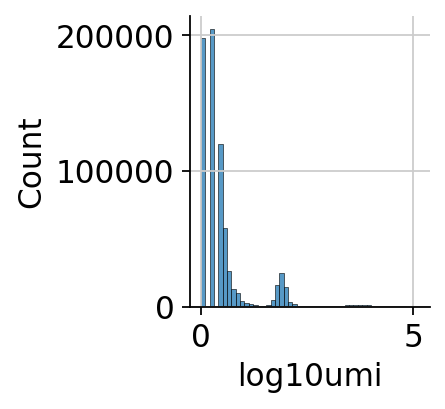

In [20]:
mu.pl.histogram(mdata_raw['rna'], ['log10umi'], bins=50)
#The threshold is usually chosen to be at a local minimum between the two peaks 
#or where the counts drop significantly between the low UMI peak and the higher UMI values.

#A peak at the lower end, representing empty droplets with low UMI counts.
#A peak or shoulder at a higher end, representing droplets containing cells with higher UMI counts.

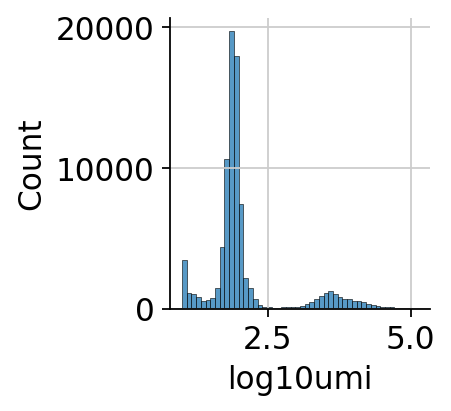

In [21]:
mu.pl.histogram(mdata_raw['rna'][mdata_raw['rna'].obs.log10umi >= 1], ['log10umi'], bins=50)
#Left Boundary(1.5): This boundary is set just above the initial rise in the distribution. 
#Droplets with log10UMI counts below this point are likely to be considered as having very low UMI counts, which could be technical noise or very few molecules, typically characteristic of empty droplets.

#Right Boundary(2.5): This boundary is set before the main peak at around log10UMI=2, where the majority of true droplets containing cells are located. Setting the boundary here ensures that droplets with higher UMI counts, which are likely to contain cells, are excluded from being classified as empty.

In [22]:
# isotype antibody controls are available that also can be taken into account by the normalisation method
isotypes = mdata_raw['prot'].var_names[mdata_raw['prot'].var_names.str.contains("Isotype")].values
isotypes

array(['Isotype.Rat.IgG1bl', 'Isotype.Hamster.IgG',
       'Isotype.Mouse.IgG2ak', 'Isotype.Mouse.IgG1k',
       'Isotype.Mouse.IgG2bk', 'Isotype.Rat.IgG1bk', 'Isotype.Rat.IgG2ak',
       'Isotype.Rat.IgG2ck', 'Isotype.Rat.IgG2bk'], dtype=object)

In [23]:
#save counts to compare
mdata["prot"].layers["counts"] = mdata["prot"].X
mdata["prot"].X = mdata["prot"].layers["counts"]

In [24]:
#Normalise counts in mdata:
#empty_counts_range : this specifies the minimum and maximum log10-counts for a droplet to be considered empty.
pt.pp.dsb(mdata, mdata_raw, empty_counts_range=(1.5, 2.5), isotype_controls=isotypes, random_state=1)

/tmp/ipykernel_442402/3153743726.py:3: DeprecationWarning: empty_counts_range will be deprecated in the future versions
  pt.pp.dsb(mdata, mdata_raw, empty_counts_range=(1.5, 2.5), isotype_controls=isotypes, random_state=1)


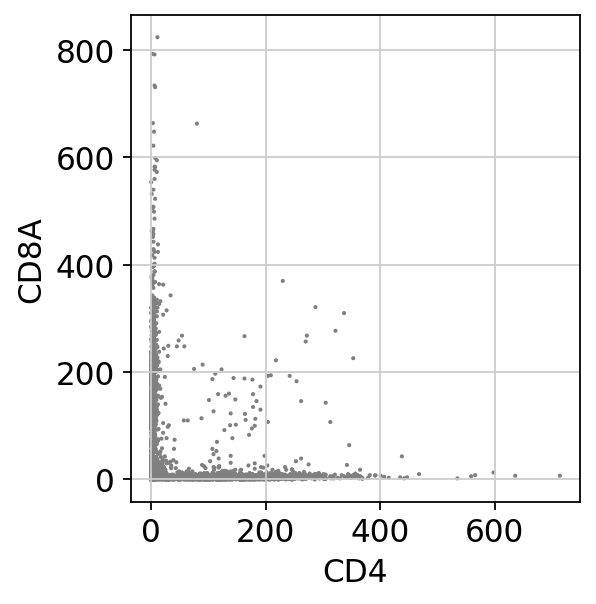

In [25]:
sc.pl.scatter(mdata['prot'], x="CD4", y="CD8A",layers="counts")

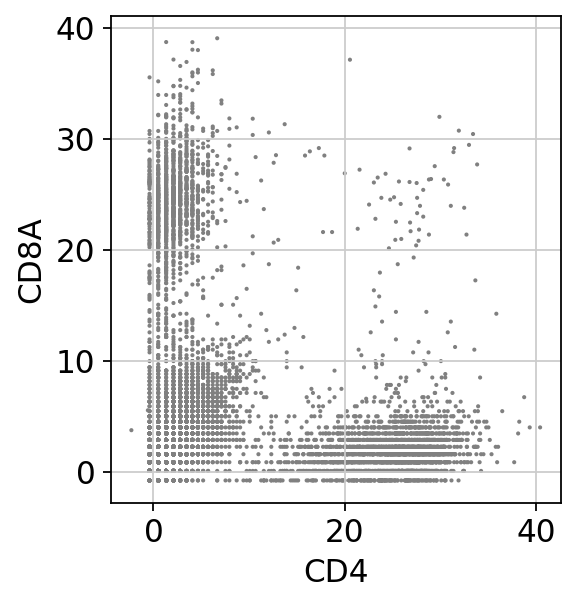

In [26]:
sc.pl.scatter(mdata['prot'], x="CD4", y="CD8A")

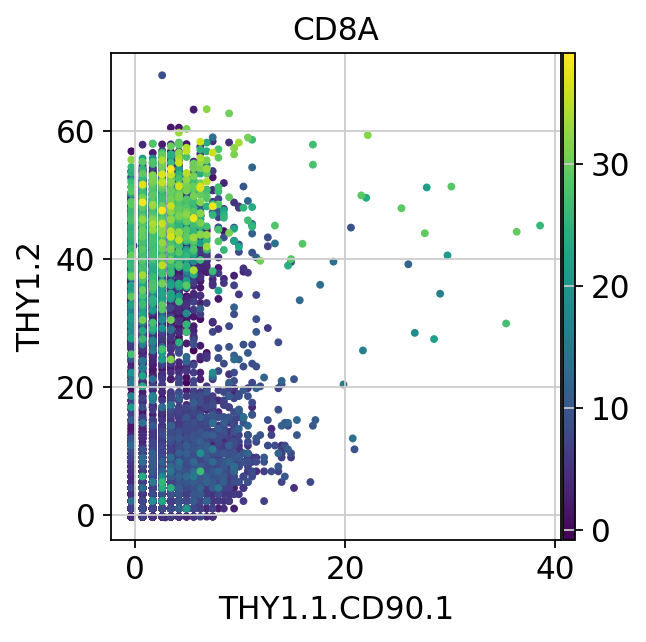

In [27]:
sc.pl.scatter(mdata['prot'], x="THY1.1.CD90.1", y="THY1.2", color='CD8A', size=50)

## doublet detection

In [28]:
prot_names=mdata.mod['prot'].var_names
"CD14" in prot_names

False

In [29]:
mdata

MuData object with n_obs × n_vars = 8708 × 55632
  obs:	'HT1', 'HT2', 'HT3', 'HT4', 'HT5', 'HT6', 'HT7', 'most_likely_hypothesis', 'cluster_feature', 'negative_hypothesis_probability', 'singlet_hypothesis_probability', 'doublet_hypothesis_probability', 'Classification', 'sample', 'condition'
  var:	'gene_ids', 'feature_types'
  2 modalities
    rna:	8708 x 55487
      var:	'gene_ids', 'feature_types'
    prot:	8708 x 145
      obs:	'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts'
      var:	'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
      layers:	'counts'

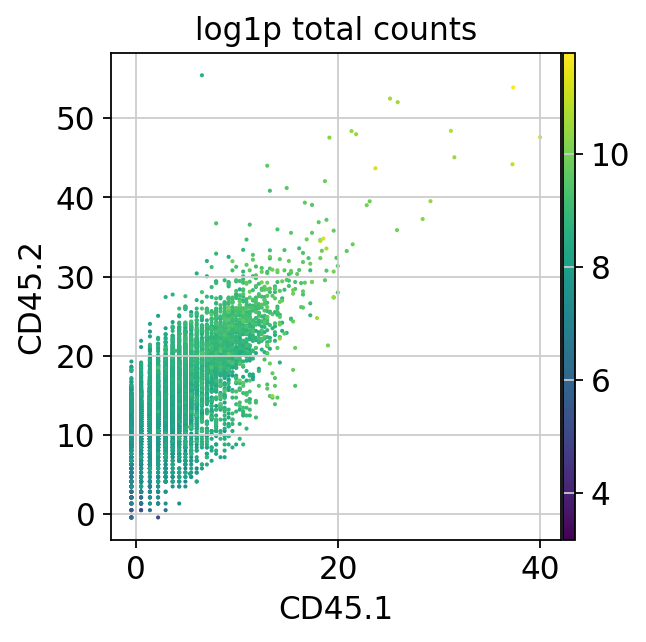

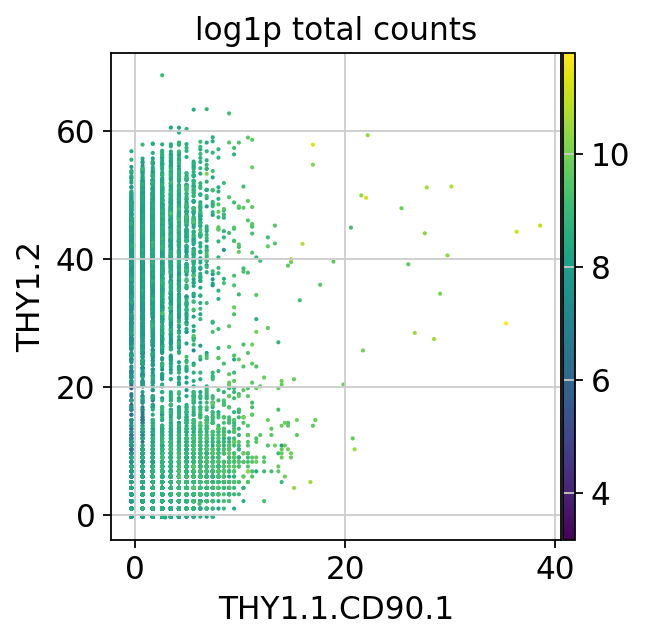

In [30]:
# in the expr, we only have CD45.2, no CD45.1; only have thy1.2, no thy1.1
sc.pl.scatter(mdata['prot'], x="CD45.1", y="CD45.2",color="log1p_total_counts")
sc.pl.scatter(mdata['prot'], x="THY1.1.CD90.1", y="THY1.2",color="log1p_total_counts")

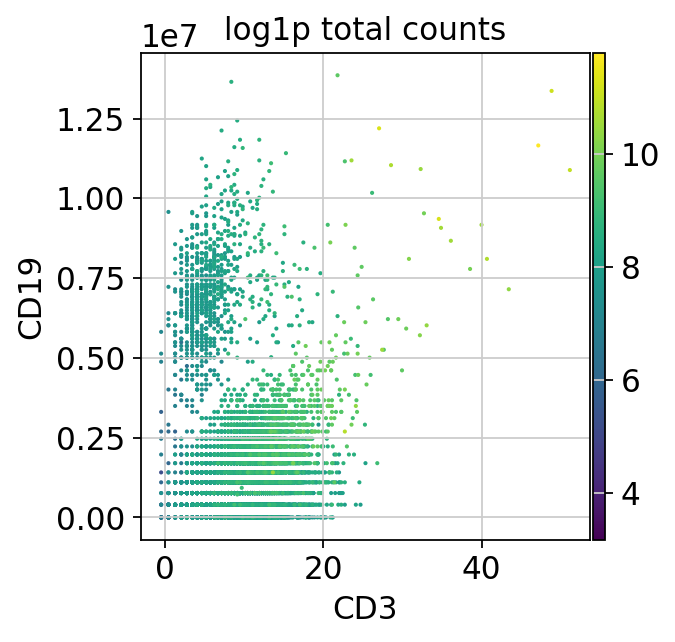

In [31]:
sc.pl.scatter(mdata['prot'], x="CD3", y="CD19",color="log1p_total_counts")
#T cells and B cells 

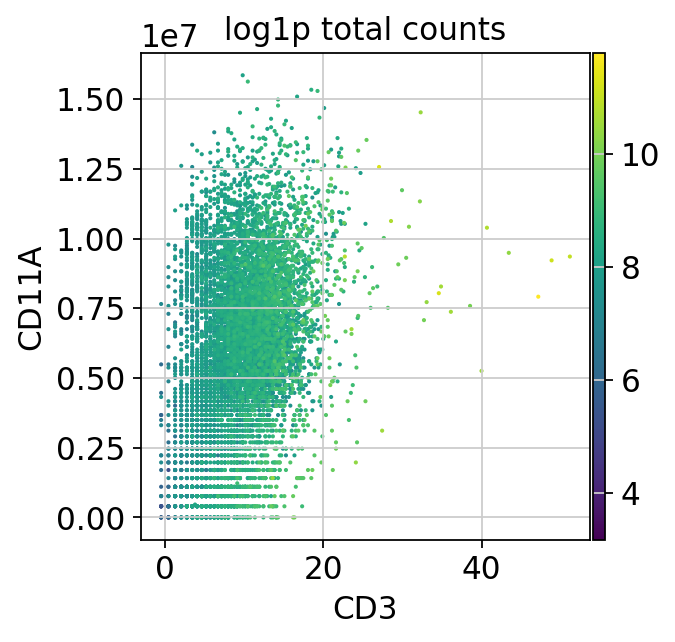

In [32]:
sc.pl.scatter(mdata['prot'], x="CD3", y="CD11A",color="log1p_total_counts")

In [33]:
filter = ["CD3", "CD19", "CD11A", "CD45.1", "THY1.1.CD90.1"]
temp = mdata["prot"][:, filter].X.T.tolist()

In [34]:
mdata["prot"].obs["doublets_markers"] = [
    (temp[0][i] > 40 and temp[1][i] > 1e7) or 
    (temp[0][i] > 50 and temp[2][i] > 10000) or
    (temp[3][i] > 30) or
    (temp[4][i] > 30) 
    for i in range(mdata.shape[0]) # if we have 100 cells, it will be 0,1,2,...99
]
mdata["prot"].obs["doublets_markers"] = (
    mdata["prot"].obs["doublets_markers"].astype(str)
)

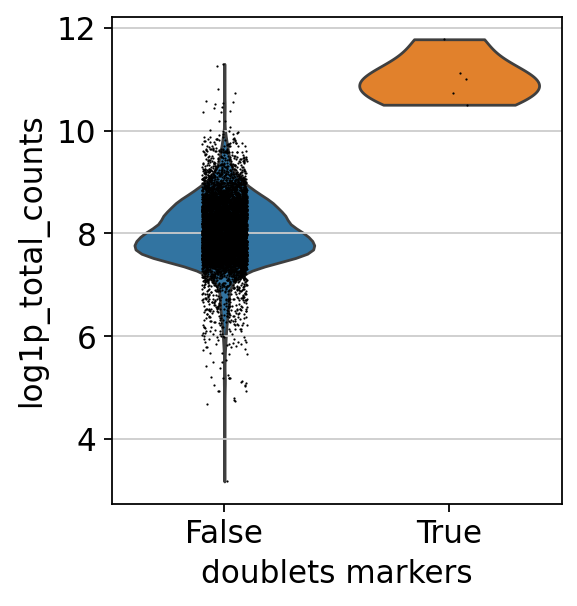

In [35]:
sc.pl.violin(mdata["prot"], keys="log1p_total_counts", groupby="doublets_markers")

In [36]:
mdata["prot"].obs['doublets_markers'].value_counts()

doublets_markers
False    8703
True        5
Name: count, dtype: int64

In [37]:
# remove doublets
mdata.update()
mdata = mdata[mdata.obs.loc[mdata["prot"].obs_names].index]
mdata = mdata[mdata["prot"].obs["doublets_markers"] == "False"].copy()

In [38]:
mdata

MuData object with n_obs × n_vars = 8703 × 55632
  obs:	'HT1', 'HT2', 'HT3', 'HT4', 'HT5', 'HT6', 'HT7', 'most_likely_hypothesis', 'cluster_feature', 'negative_hypothesis_probability', 'singlet_hypothesis_probability', 'doublet_hypothesis_probability', 'Classification', 'sample', 'condition'
  var:	'gene_ids', 'feature_types'
  2 modalities
    rna:	8703 x 55487
      var:	'gene_ids', 'feature_types'
    prot:	8703 x 145
      obs:	'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'doublets_markers'
      var:	'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
      uns:	'doublets_markers_colors'
      layers:	'counts'

## Downstream analysis

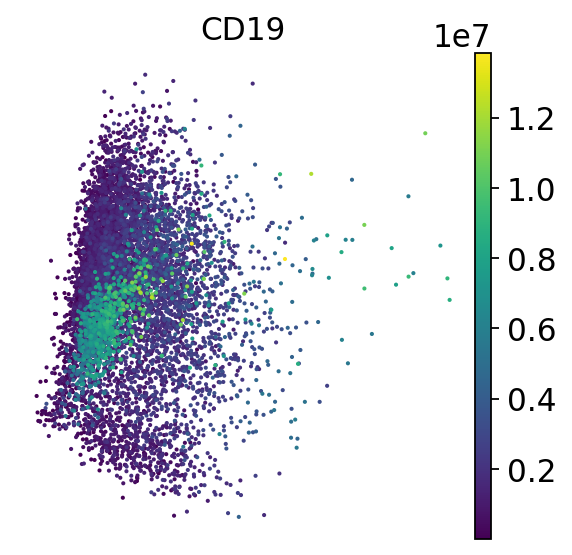

In [39]:
sc.tl.pca(mdata['prot'])
sc.pl.pca(mdata['prot'], color='CD19')

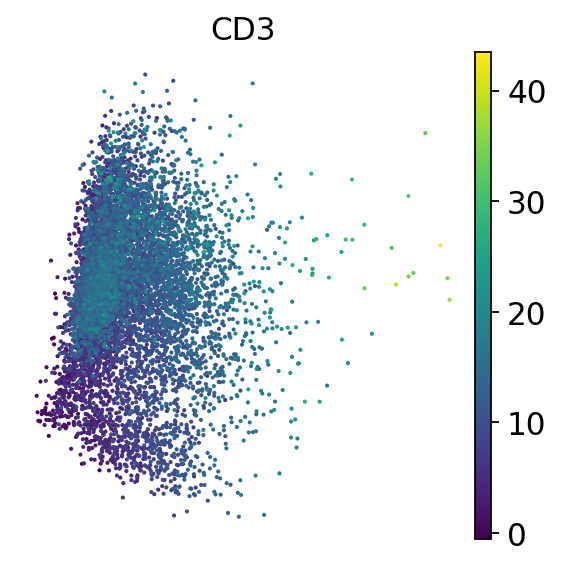

In [40]:
sc.pl.pca(mdata['prot'], color='CD3')

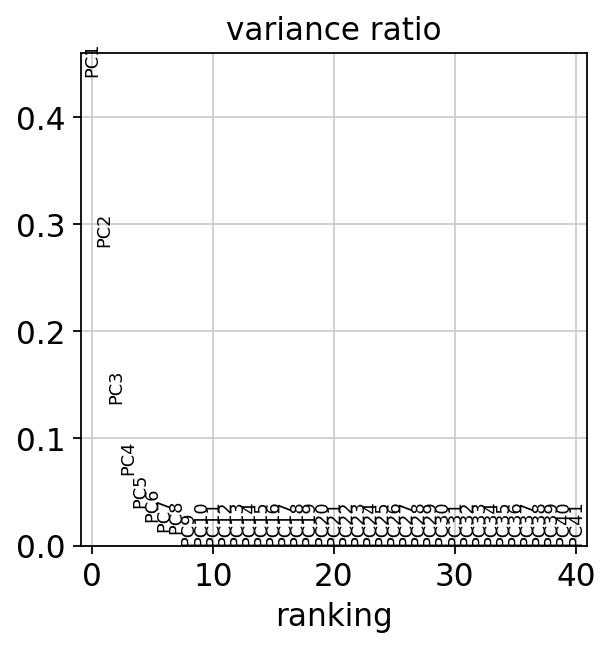

In [41]:
sc.pl.pca_variance_ratio(mdata["prot"], n_pcs=40)

In [42]:
sc.pp.neighbors(mdata['prot'], n_pcs=10)
sc.tl.umap(mdata['prot'], random_state=1)

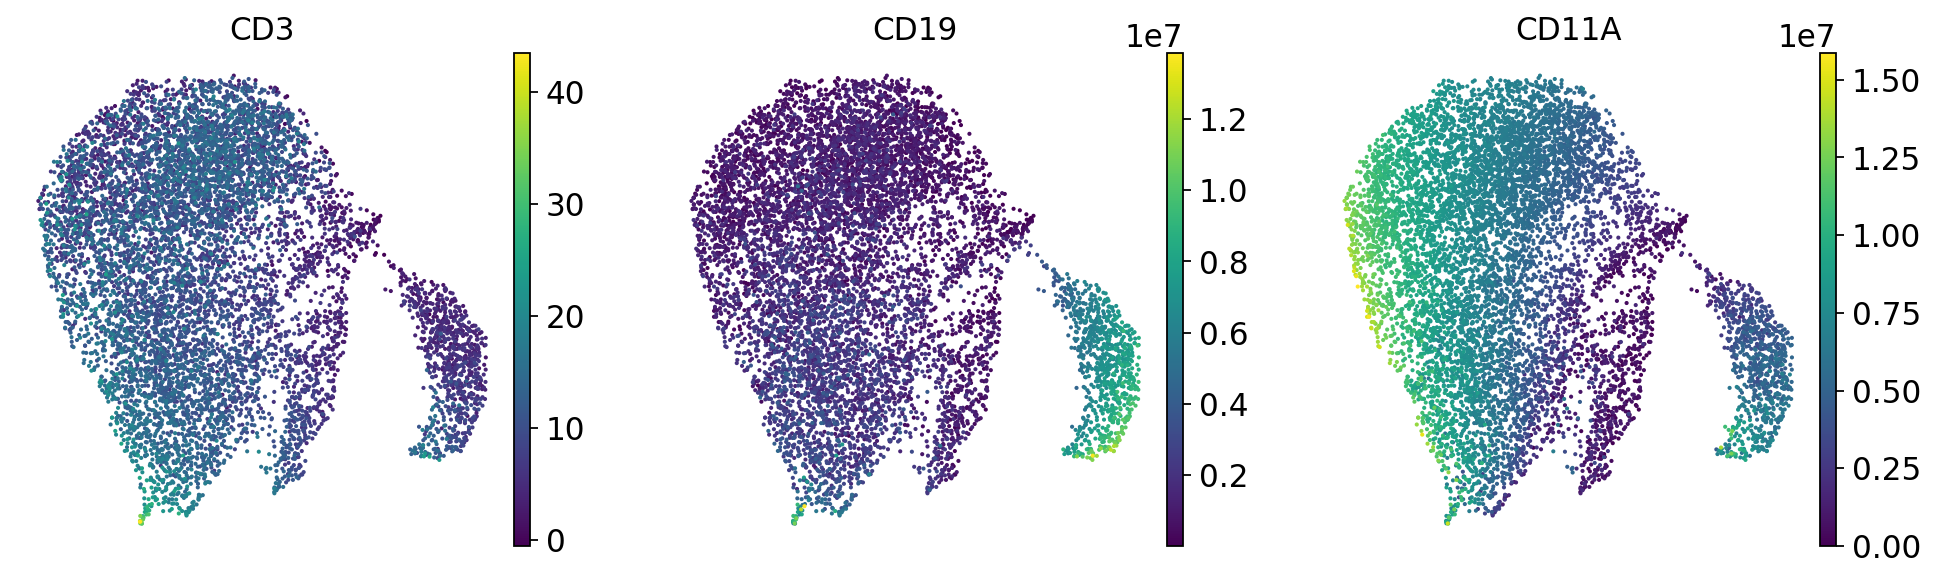

In [43]:
sc.pl.umap(mdata['prot'], color=['CD3','CD19','CD11A'])

# RNA

In [44]:
rna = mdata.mod['rna']
rna = rna.copy()
rna

AnnData object with n_obs × n_vars = 8703 × 55487
    var: 'gene_ids', 'feature_types'

## QC

In [45]:
#metrics
sc.pp.calculate_qc_metrics(rna, inplace=True, percent_top=None)
# mitochondrial genes
rna.var["mt"] = rna.var_names.str.startswith("mt-")
# ribosomal genes
rna.var["ribo"] = rna.var_names.str.startswith(("Rps", "Rpl"))
# hemoglobin genes.
rna.var["hb"] = rna.var_names.str.contains(("^Hba|^Hbb"))
sc.pp.calculate_qc_metrics(
    rna, qc_vars=["mt", "ribo", "hb"], percent_top=None, log1p=False, inplace=True
)

dying cells: cells with broken membranes whose cytoplasmic mRNA has leaked out-- a low count depth, few detected genes and a high fraction of mitochondrial reads.

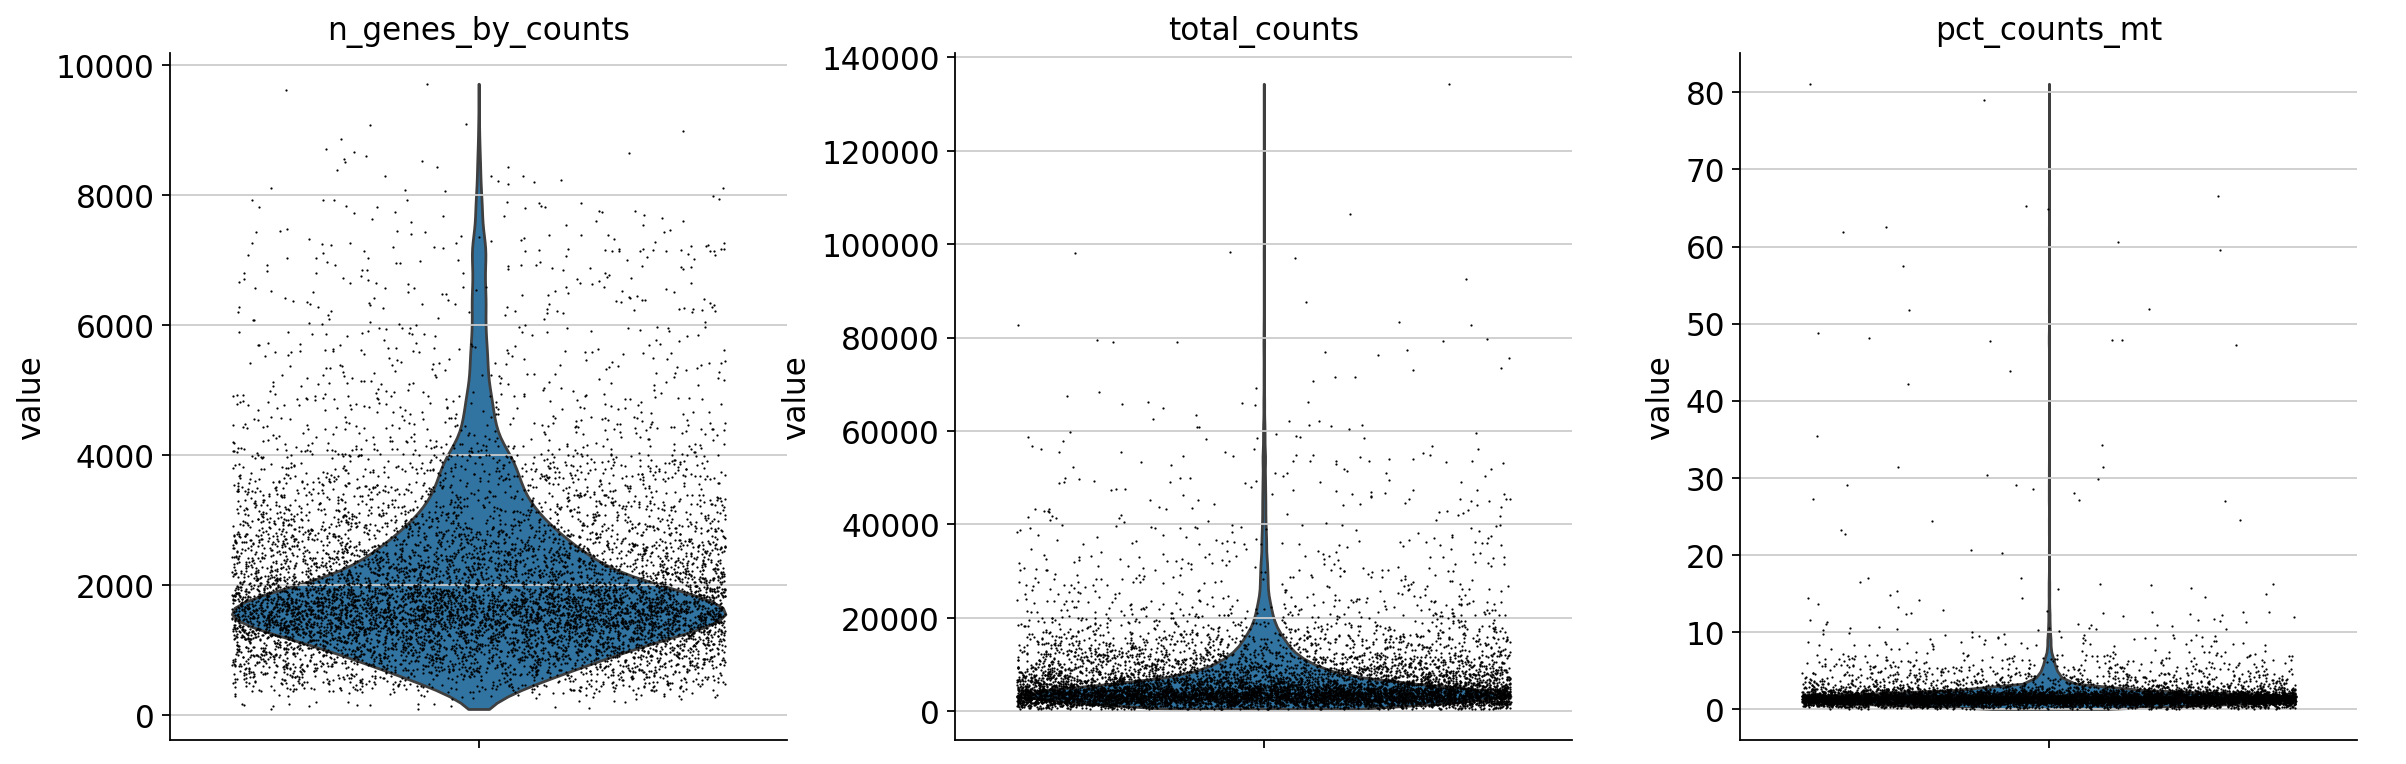

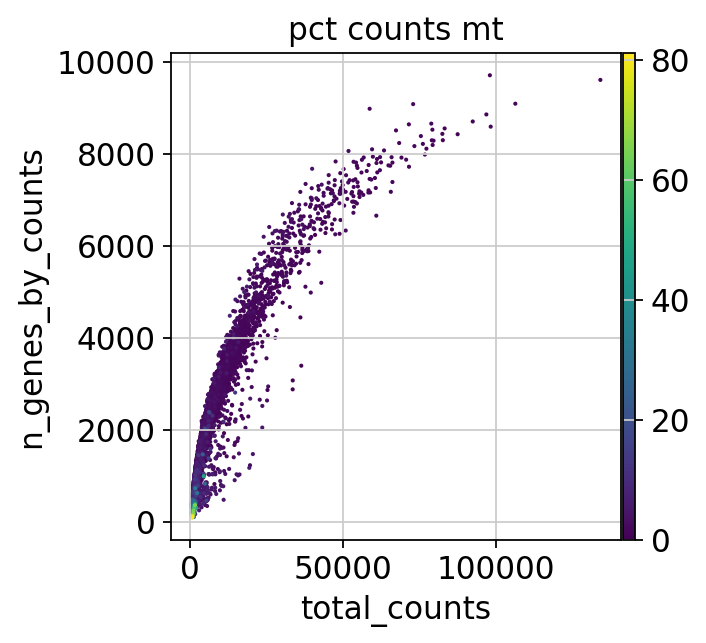

In [46]:
sc.pl.violin(rna, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)
sc.pl.scatter(rna, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

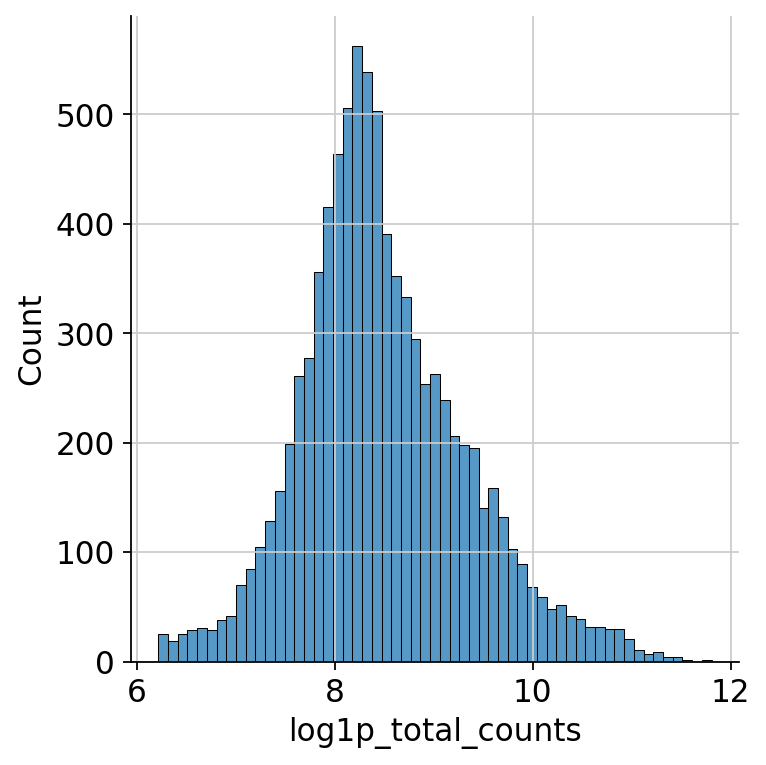

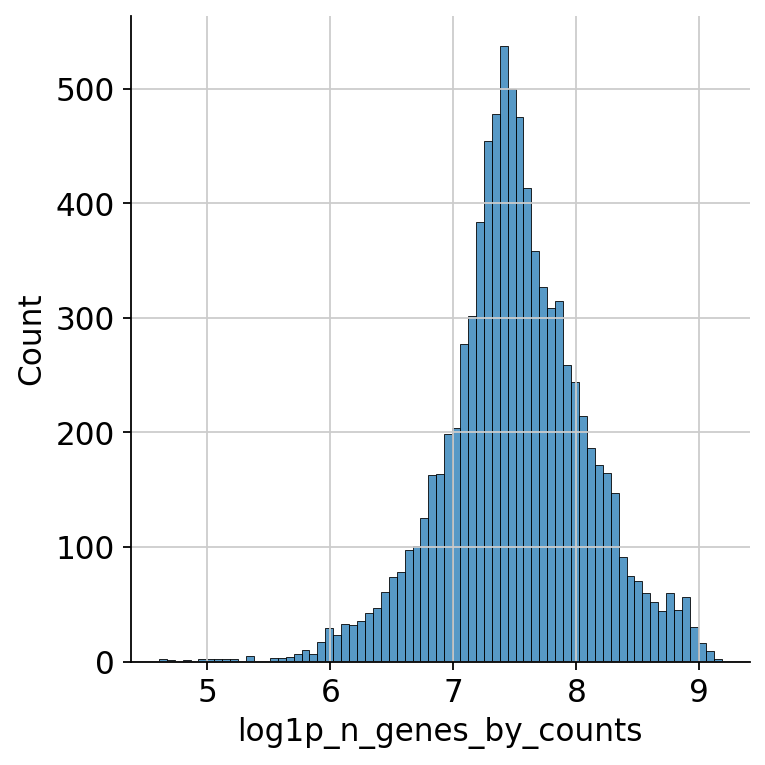

In [47]:
sns.displot(rna.obs["log1p_total_counts"], kde=False)
sns.displot(rna.obs["log1p_n_genes_by_counts"], kde=False)

In [48]:
from scipy.stats import median_abs_deviation
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    
    median = np.median(M)
    MAD = median_abs_deviation(M)
    counts = outlier.sum()

    print(f"number of outliers in terms of {metric}: {counts}, median: {median}, MAD: {MAD}")
    
    return outlier

In [49]:
rna.obs["outlier"] = (
    is_outlier(rna, "log1p_total_counts", 5.5)
    | is_outlier(rna, "log1p_n_genes_by_counts", 5)
)
rna.obs.outlier.value_counts()

number of outliers in terms of log1p_total_counts: 33, median: 8.375399589538574, MAD: 0.4889230728149414
number of outliers in terms of log1p_n_genes_by_counts: 46, median: 7.484930283289661, MAD: 0.33309765524106716


outlier
False    8626
True       77
Name: count, dtype: int64

In [50]:
rna.obs["mt_outlier"] = (
    rna.obs["pct_counts_mt"] > 10
)
rna.obs.mt_outlier.value_counts()

mt_outlier
False    8613
True       90
Name: count, dtype: int64

In [51]:
print(f"Total number of cells: {rna.n_obs}")
rna = rna[(~rna.obs.outlier) & (~rna.obs.mt_outlier)].copy()

print(f"Number of cells after filtering out low quality cells: {rna.n_obs}")

Total number of cells: 8703
Number of cells after filtering out low quality cells: 8568


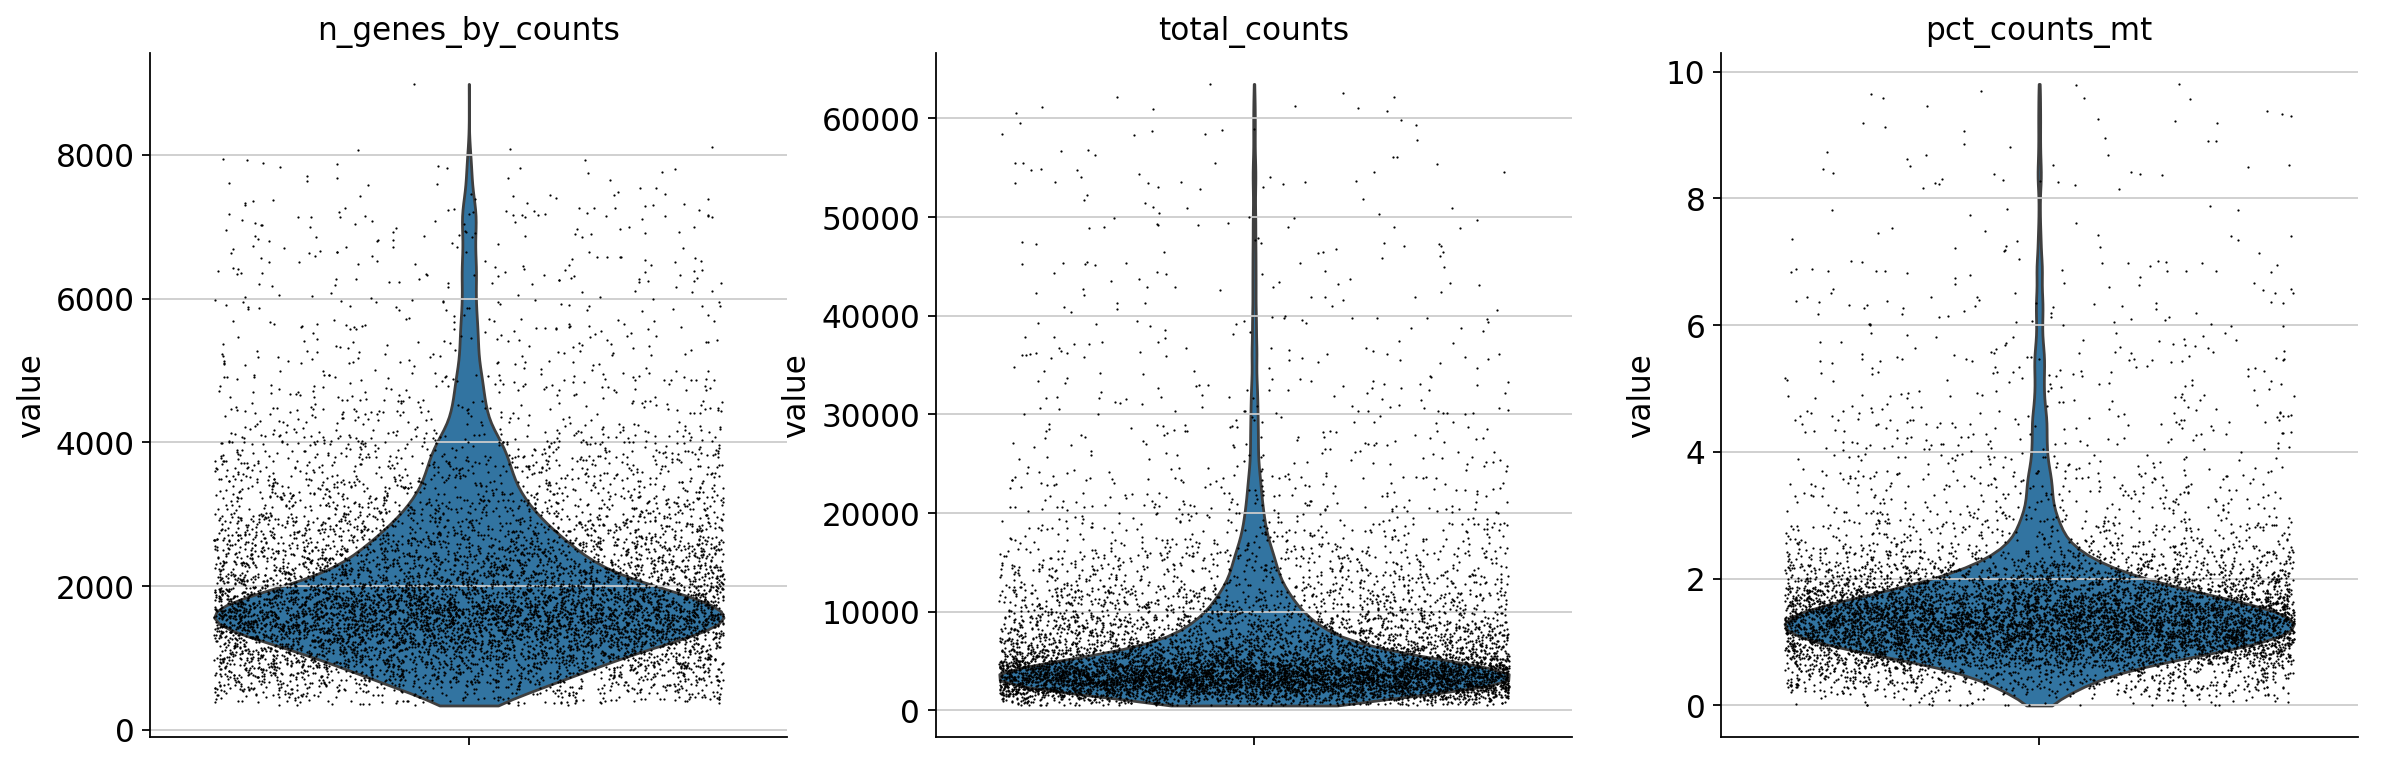

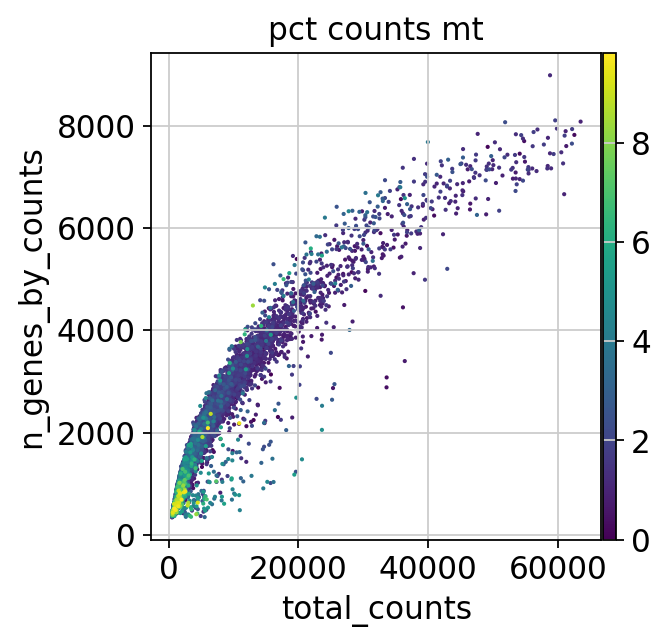

In [52]:
sc.pl.violin(rna, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)
sc.pl.scatter(rna, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [53]:
rna

AnnData object with n_obs × n_vars = 8568 × 55487
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt', 'ribo', 'hb'

In [54]:
mdata["rna"]

AnnData object with n_obs × n_vars = 8703 × 55487
    var: 'gene_ids', 'feature_types'

## Normalization

In [55]:
rna.layers['counts'] = rna.X.copy()

In [56]:
rna

AnnData object with n_obs × n_vars = 8568 × 55487
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt', 'ribo', 'hb'
    layers: 'counts'

In [57]:
sc.pp.normalize_total(rna, target_sum=1e4)
sc.pp.log1p(rna)

In [58]:
rna.layers["log1p_norm"] = rna.X.copy()

In [59]:
rna

AnnData object with n_obs × n_vars = 8568 × 55487
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt', 'ribo', 'hb'
    uns: 'log1p'
    layers: 'counts', 'log1p_norm'

## Feature Selection

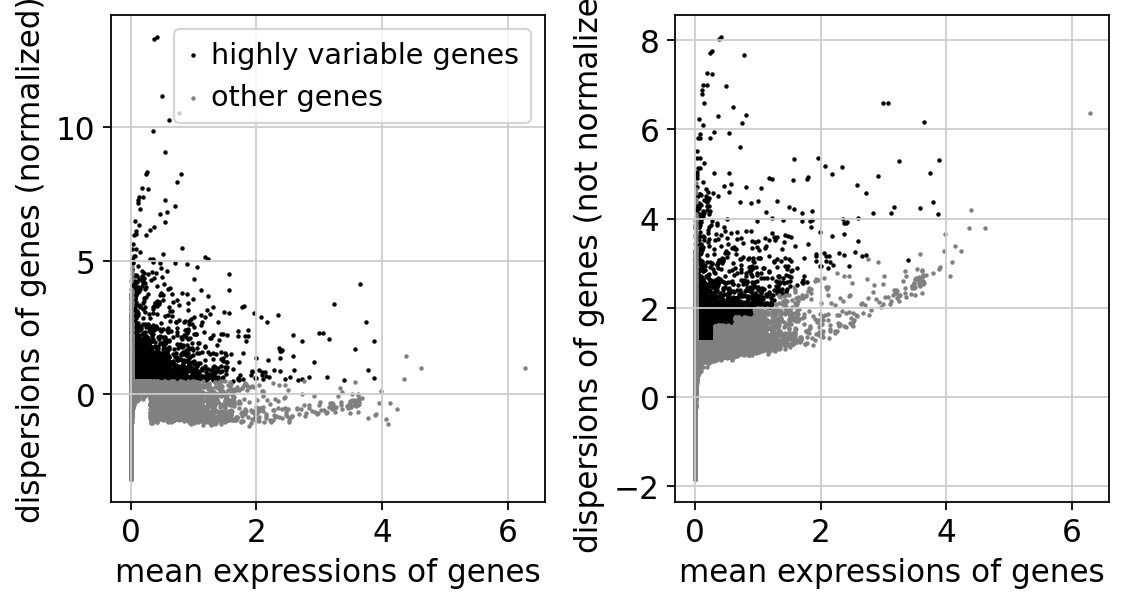

3945

In [60]:
sc.pp.highly_variable_genes(rna, min_mean=0.02, max_mean=4, min_disp=0.5)
sc.pl.highly_variable_genes(rna)
np.sum(rna.var.highly_variable)

## Scaling

In [61]:
sc.pp.scale(rna, max_value=10)

In [62]:
rna.layers["scaled"] = rna.X.copy()
rna

AnnData object with n_obs × n_vars = 8568 × 55487
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt', 'ribo', 'hb', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg'
    layers: 'counts', 'log1p_norm', 'scaled'

## PCA and neighborhood graph
PCA offers the advantage that it is highly interpretable and computationally efficient. However, as scRNA-seq datasets are rather sparse due to dropout events and therefore highly non-linear, visualization with the linear dimensionality reduction technique PCA is not very appropriate. PCA is typically used to select the top 10-50 PCs which are used for downstream analysis tasks.

In [63]:
sc.tl.pca(rna, svd_solver='arpack')

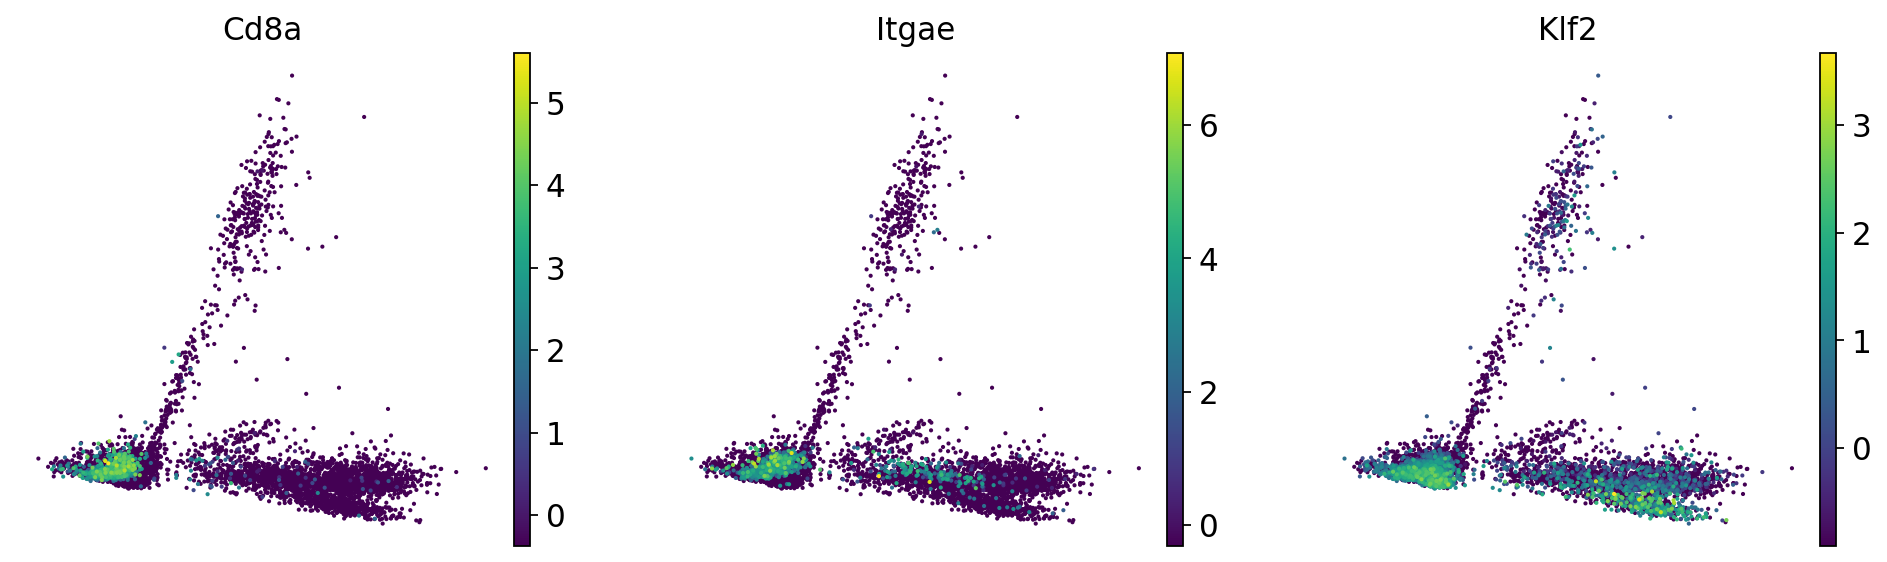

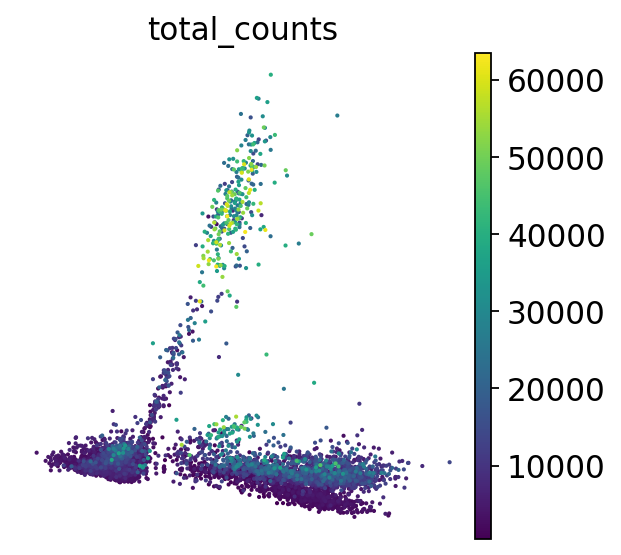

In [64]:
sc.pl.pca(rna, color=['Cd8a', 'Itgae', 'Klf2'])
sc.pl.pca_scatter(rna, color="total_counts")

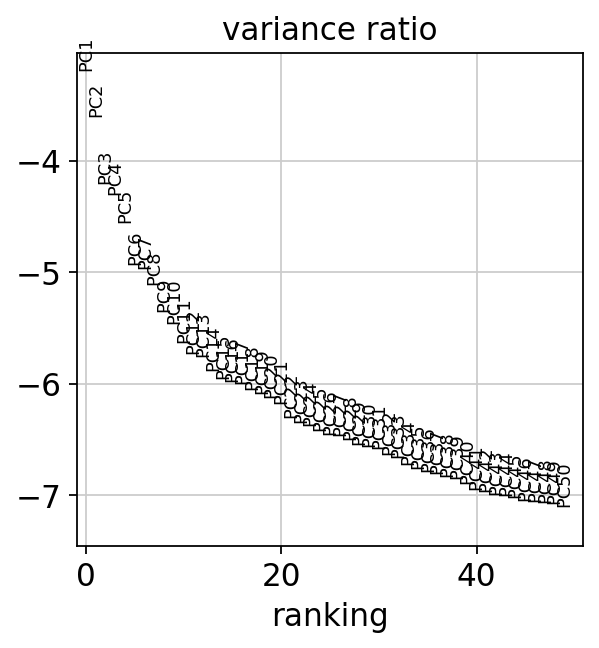

In [65]:
sc.pl.pca_variance_ratio(rna, log=True,n_pcs=50)

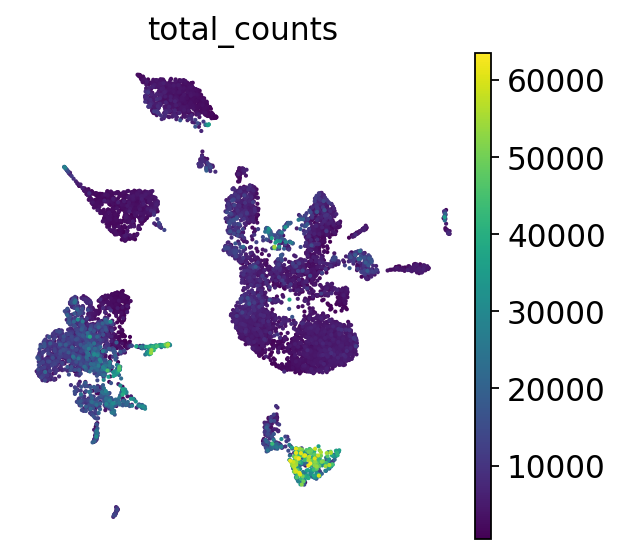

In [66]:
#umap
sc.pp.neighbors(rna, n_neighbors=10, n_pcs=40)
sc.tl.umap(rna, spread=1., min_dist=.5, random_state=11)
sc.pl.umap(rna, color="total_counts")

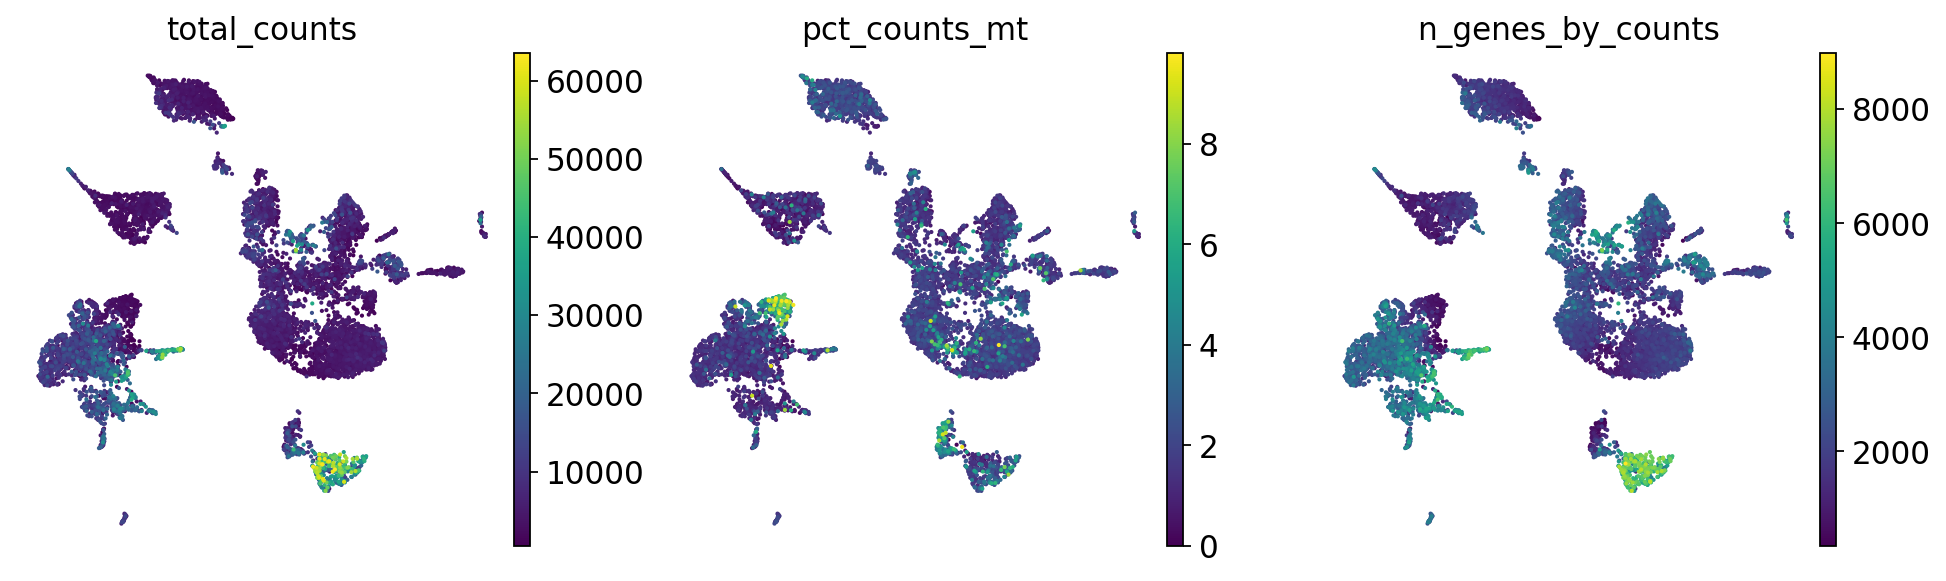

In [67]:
# inspecting quality control
sc.pl.umap(
    rna,
    color=["total_counts", "pct_counts_mt", "n_genes_by_counts"],
)

## clustering

In [68]:
sc.tl.leiden(rna, key_added="leiden_res0_25", resolution=0.25)
sc.tl.leiden(rna, key_added="leiden_res0_5", resolution=0.5)
sc.tl.leiden(rna, key_added="leiden_res0_75", resolution=0.75)
sc.tl.leiden(rna, key_added="leiden_res1", resolution=1.0)

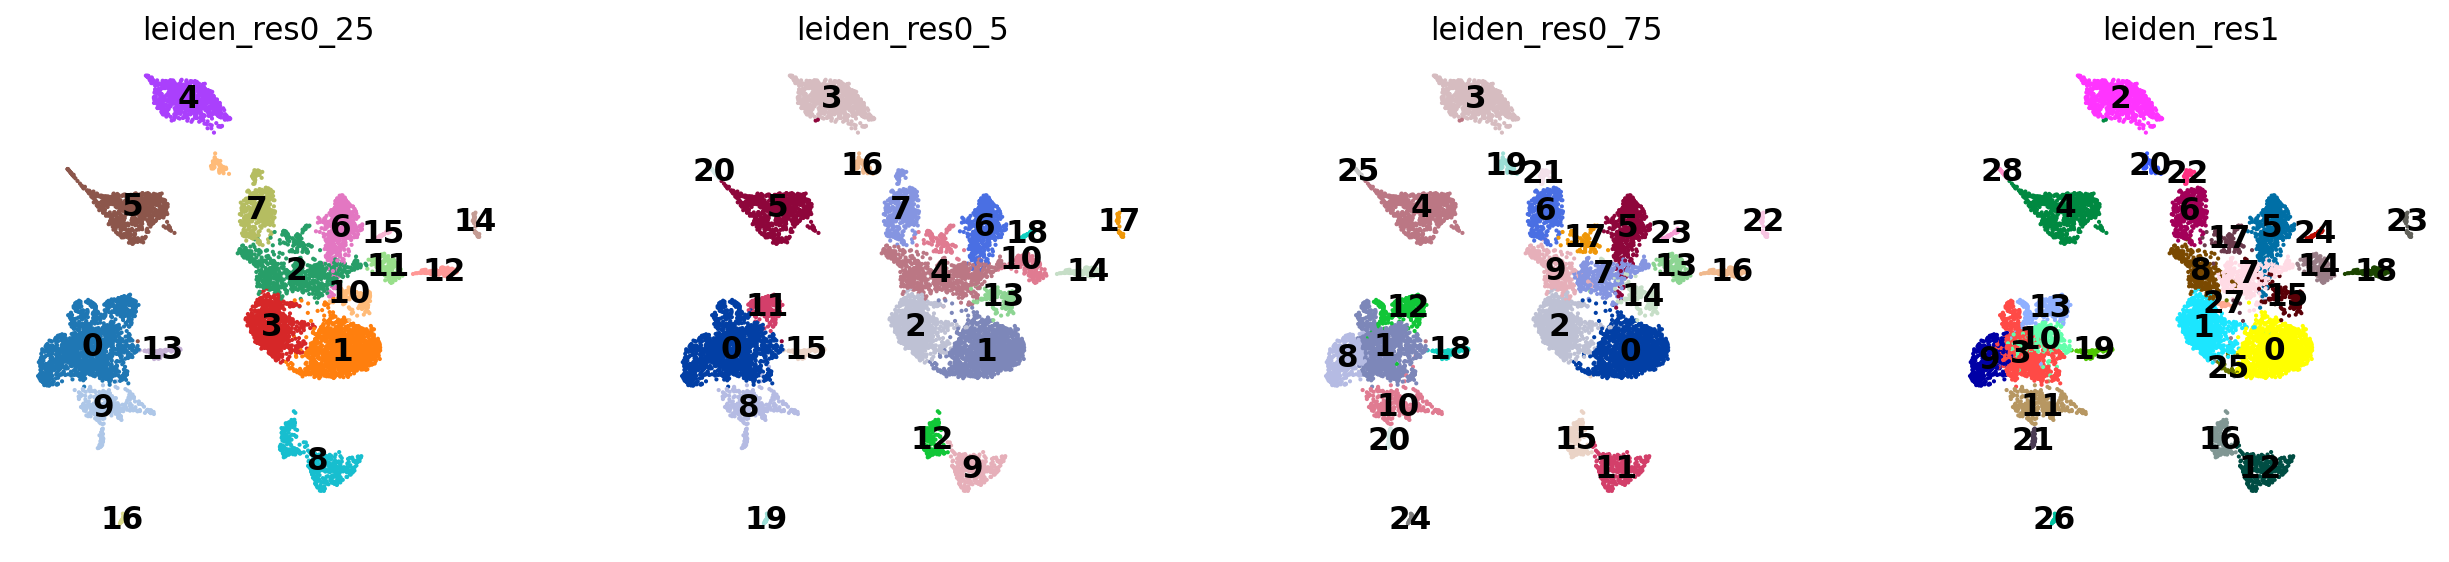

In [69]:
sc.pl.umap(
    rna,
    color=["leiden_res0_25", "leiden_res0_5", "leiden_res0_75","leiden_res1"],
    legend_loc="on data",
)

## Magic

In [70]:
sc.external.pp.magic(rna, name_list='all_genes', n_jobs=12, verbose=True)

Calculating MAGIC...
  Running MAGIC on 8568 cells and 55487 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 5.98 seconds.
    Calculating KNN search...
    Calculated KNN search in 4.32 seconds.
    Calculating affinities...
    Calculated affinities in 4.33 seconds.
  Calculated graph and diffusion operator in 14.64 seconds.
  Running MAGIC with `solver='exact'` on 55487-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
  Calculating imputation...
  Calculated imputation in 16.05 seconds.
Calculated MAGIC in 31.09 seconds.


In [71]:
rna.layers["magiced"] = rna.X.copy()
rna

AnnData object with n_obs × n_vars = 8568 × 55487
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'leiden_res0_25', 'leiden_res0_5', 'leiden_res0_75', 'leiden_res1'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt', 'ribo', 'hb', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden_res0_25', 'leiden_res0_5', 'leiden_res0_75', 'leiden_res1', 'leiden_res0_25_colors', 'leiden_res0_5_colors', 'leiden_res0_75_colors', 'leiden_res1_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'log1p_norm', 'scaled', 'magiced'
    obsp: 'distances', 'connectivities'

In [72]:
mdata.mod['rna'] = rna
mdata.update()

In [73]:
mdata

MuData object with n_obs × n_vars = 8703 × 55632
  obs:	'HT1', 'HT2', 'HT3', 'HT4', 'HT5', 'HT6', 'HT7', 'most_likely_hypothesis', 'cluster_feature', 'negative_hypothesis_probability', 'singlet_hypothesis_probability', 'doublet_hypothesis_probability', 'Classification', 'sample', 'condition'
  var:	'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
  2 modalities
    rna:	8568 x 55487
      obs:	'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'leiden_res0_25', 'leiden_res0_5', 'leiden_res0_75', 'leiden_res1'
      var:	'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt', 'ribo', 'hb', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
      uns:	'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden_res0_25', 'leiden_res0_5', 'leiden_res0_75', 'leiden_res1', 'leiden_res0_25_colors', 'leiden_res0_5_colors', 'leiden_res0_75_colors', 'leiden_res1_colors'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'counts', 'log1p_norm', 'scaled', 'magiced'
      obsp:	'distances', 'connectivities'
    prot:	8703 x 145
      obs:	'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'doublets_markers'
      var:	'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
      uns:	'doublets_markers_colors', 'pca', 'neighbors', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'counts'
      obsp:	'distances', 'connectivities'

In [74]:
mdata.mod['rna'].X = rna.layers["log1p_norm"]

# Multi-omics integration

In [75]:
mu.pp.intersect_obs(mdata)
mdata

MuData object with n_obs × n_vars = 8568 × 55632
  obs:	'HT1', 'HT2', 'HT3', 'HT4', 'HT5', 'HT6', 'HT7', 'most_likely_hypothesis', 'cluster_feature', 'negative_hypothesis_probability', 'singlet_hypothesis_probability', 'doublet_hypothesis_probability', 'Classification', 'sample', 'condition'
  var:	'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
  2 modalities
    rna:	8568 x 55487
      obs:	'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'leiden_res0_25', 'leiden_res0_5', 'leiden_res0_75', 'leiden_res1'
      var:	'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt', 'ribo', 'hb', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
      uns:	'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden_res0_25', 'leiden_res0_5', 'leiden_res0_75', 'leiden_res1', 'leiden_res0_25_colors', 'leiden_res0_5_colors', 'leiden_res0_75_colors', 'leiden_res1_colors'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'counts', 'log1p_norm', 'scaled', 'magiced'
      obsp:	'distances', 'connectivities'
    prot:	8568 x 145
      obs:	'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'doublets_markers'
      var:	'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
      uns:	'doublets_markers_colors', 'pca', 'neighbors', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'counts'
      obsp:	'distances', 'connectivities'

## multiplex clustering

In [76]:
mu.tl.leiden(mdata, resolution=[2, .5], random_state=1)

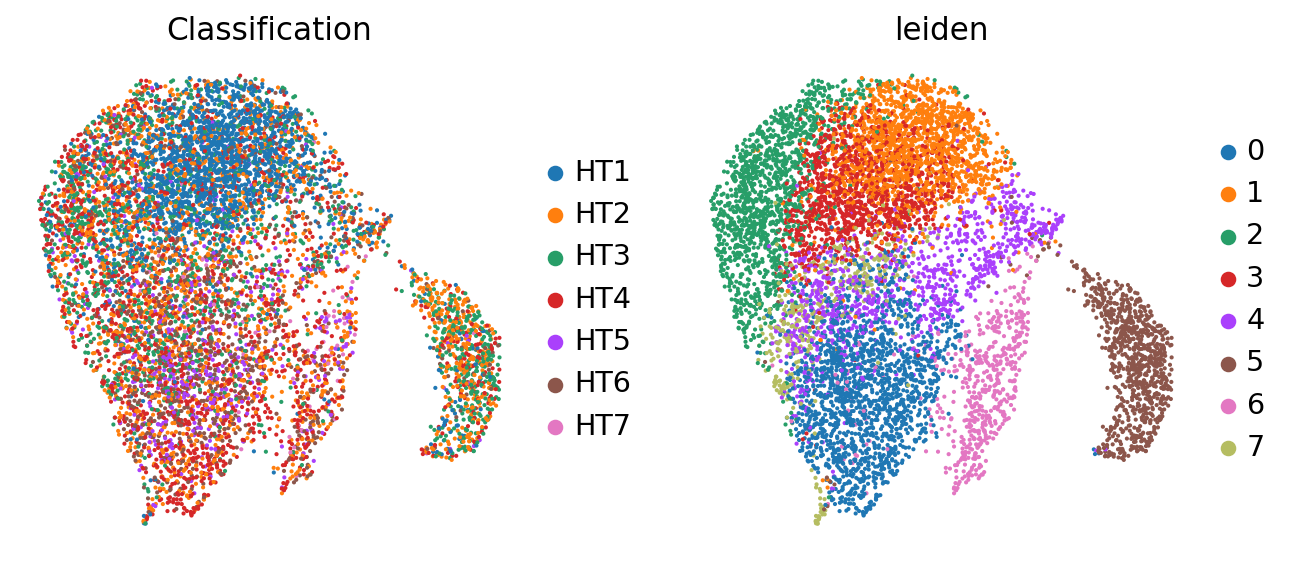

In [77]:
mu.pl.embedding(mdata, basis="prot:X_umap", color=["Classification", 'leiden'])

In [1]:
mu.pl.embedding(mdata, basis="rna:X_umap", color=['Sample', 'Itgam', 'leiden'])

NameError: name 'mu' is not defined

In [79]:
mdata.update()
mdata

MuData object with n_obs × n_vars = 8568 × 55632
  obs:	'HT1', 'HT2', 'HT3', 'HT4', 'HT5', 'HT6', 'HT7', 'most_likely_hypothesis', 'cluster_feature', 'negative_hypothesis_probability', 'singlet_hypothesis_probability', 'doublet_hypothesis_probability', 'Classification', 'sample', 'condition', 'leiden'
  var:	'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
  uns:	'leiden'
  2 modalities
    rna:	8568 x 55487
      obs:	'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'leiden_res0_25', 'leiden_res0_5', 'leiden_res0_75', 'leiden_res1'
      var:	'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt', 'ribo', 'hb', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
      uns:	'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden_res0_25', 'leiden_res0_5', 'leiden_res0_75', 'leiden_res1', 'leiden_res0_25_colors', 'leiden_res0_5_colors', 'leiden_res0_75_colors', 'leiden_res1_colors', 'leiden_colors'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'counts', 'log1p_norm', 'scaled', 'magiced'
      obsp:	'distances', 'connectivities'
    prot:	8568 x 145
      obs:	'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'doublets_markers'
      var:	'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
      uns:	'doublets_markers_colors', 'pca', 'neighbors', 'umap', 'Classification_colors', 'leiden_colors'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'counts'
      obsp:	'distances', 'connectivities'

## multi-omics factor analysis

In [80]:
mu.tl.mofa(mdata, groups_label="sample", n_factors = 30)
#outfile="models/pbmc5k_citeseq.hdf5",


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Loaded view='rna' group='Soy_2' with N=935 samples and D=55487 features...
Loaded view='rna' group='Fish_1' with N=70 samples and D=55487 features...
Loaded view='rna' group='Spleen control' with N=1825 samples and D=55487 features...
Loaded view='rna' group='Soy_1' with N=1487 samples and D=55487 features...
Loaded view='rna' group='LFD_2' with N=1743 samples and D=55487 featur

In [81]:
sc.pp.neighbors(mdata, use_rep="X_mofa")
sc.tl.umap(mdata, random_state=1)

In [84]:
mdata.obsm["X_umap_mofa"] = mdata.obsm["X_umap"].copy()

In [92]:
mdata

MuData object with n_obs × n_vars = 8568 × 55632
  obs:	'HT1', 'HT2', 'HT3', 'HT4', 'HT5', 'HT6', 'HT7', 'most_likely_hypothesis', 'cluster_feature', 'negative_hypothesis_probability', 'singlet_hypothesis_probability', 'doublet_hypothesis_probability', 'Classification', 'sample', 'condition', 'leiden'
  var:	'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
  uns:	'leiden', 'mofa', 'neighbors', 'umap', 'sample_colors'
  obsm:	'X_mofa', 'X_umap', 'X_umap_mofa'
  varm:	'LFs'
  obsp:	'distances', 'connectivities'
  2 modalities
    rna:	8568 x 55487
      obs:	'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'leiden_res0_25', 'leiden_res0_5', 'leiden_res0_75', 'leiden_res1'
      var:	'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt', 'ribo', 'hb', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
      uns:	'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden_res0_25', 'leiden_res0_5', 'leiden_res0_75', 'leiden_res1', 'leiden_res0_25_colors', 'leiden_res0_5_colors', 'leiden_res0_75_colors', 'leiden_res1_colors', 'leiden_colors'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'counts', 'log1p_norm', 'scaled', 'magiced'
      obsp:	'distances', 'connectivities'
    prot:	8568 x 145
      obs:	'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'doublets_markers'
      var:	'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
      uns:	'doublets_markers_colors', 'pca', 'neighbors', 'umap', 'Classification_colors', 'leiden_colors'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'counts'
      obsp:	'distances', 'connectivities'

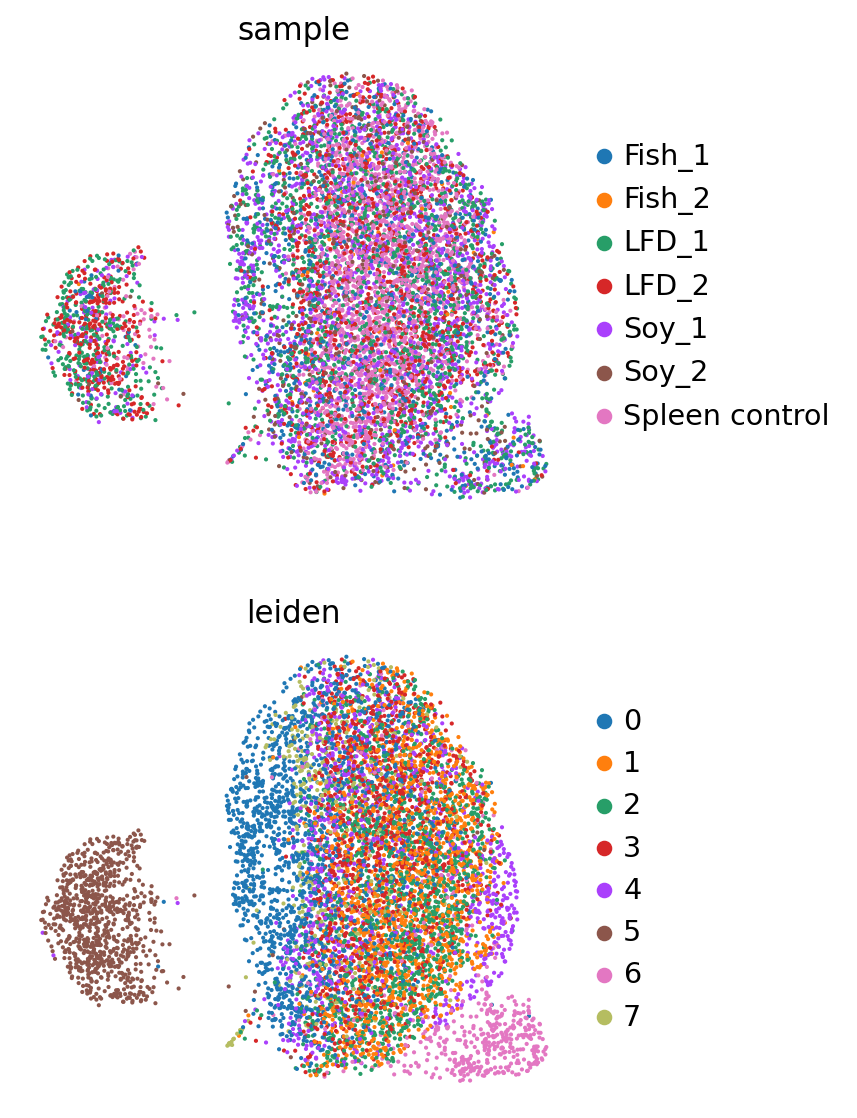

In [93]:
mu.pl.embedding(
    mdata, color=["sample","leiden"], ncols=1, basis="umap_mofa", frameon=False
)

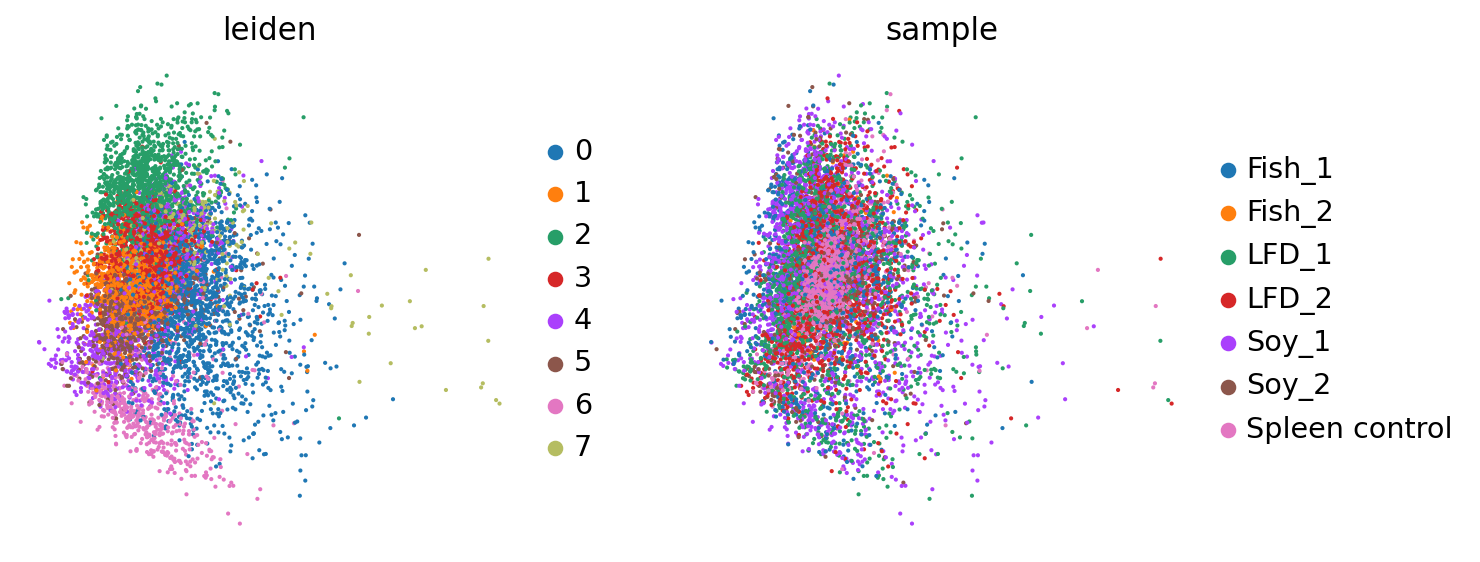

In [97]:
mu.pl.mofa(mdata, color=["leiden", "sample"])

# Save

In [105]:
mdata.update()
mdata.write("/data/msun/projects/Stephen/PDAC_scRNA/citeseq_pdac.h5mu")

In [106]:
rna.write("/data/msun/projects/Stephen/PDAC_scRNA/rna_pdac.h5ad")